# Using pre-trained FasterRCNN Model for object detection

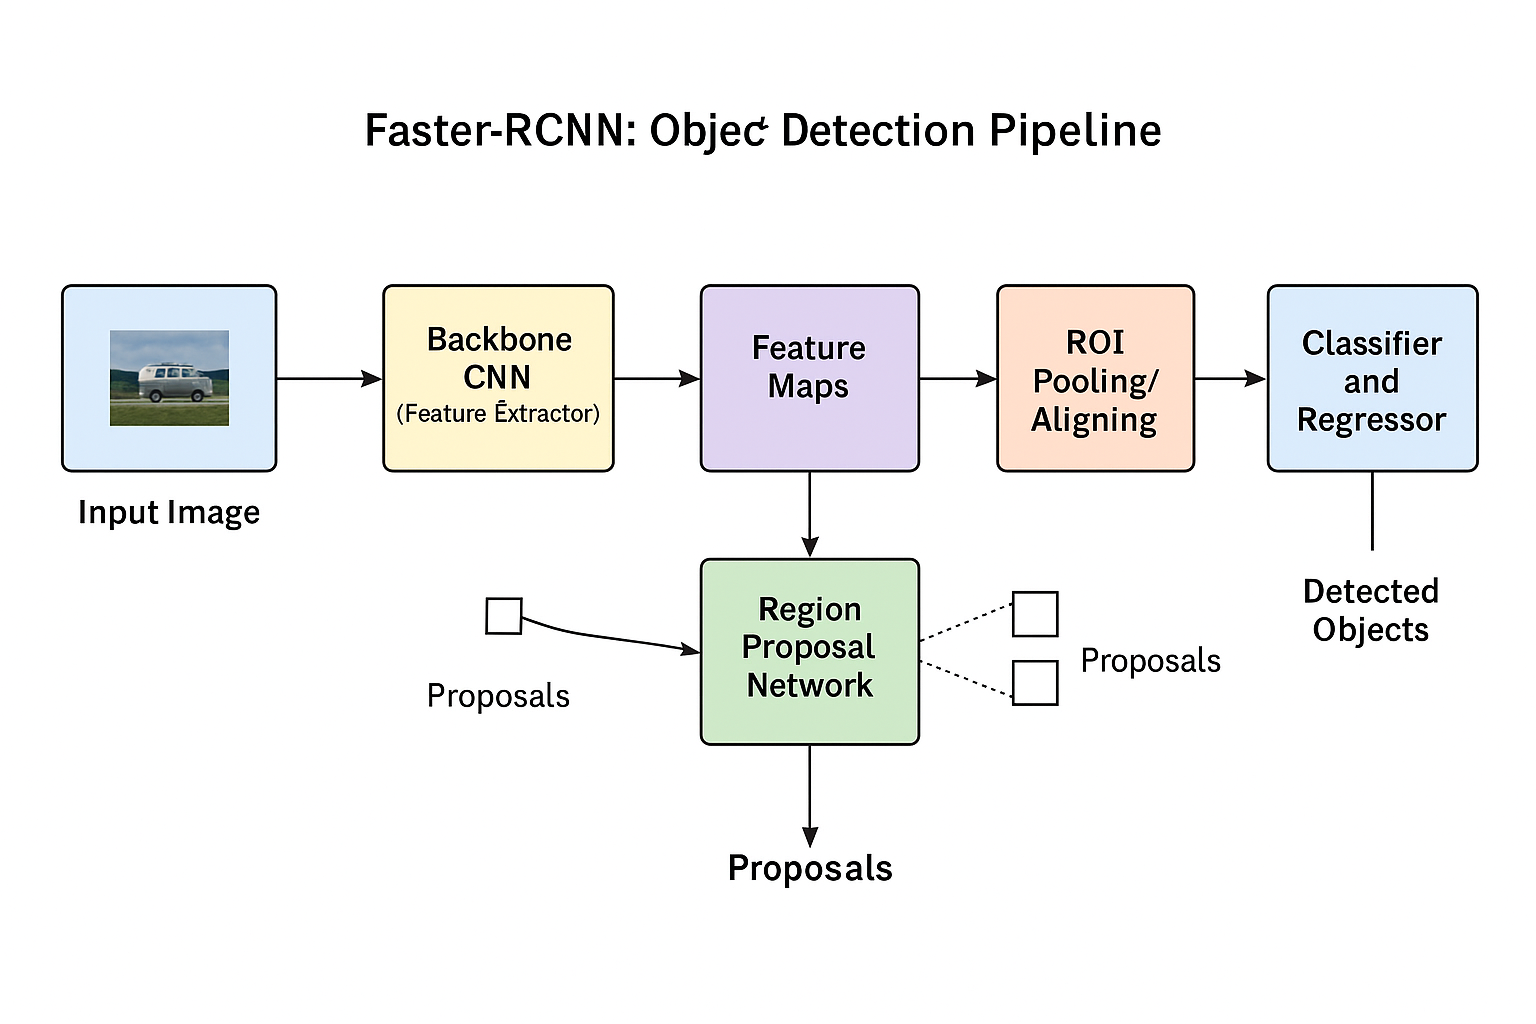

In [45]:
from IPython.display import Image, display

display(Image(filename='/kaggle/input/fasterrcnnimage/FasterRCNNImage.png', width=600))

## ROI Pooling & RPN in Our Model

- **Region Proposal Network (RPN):** Already built-in inside `fasterrcnn_resnet50_fpn`. It generates candidate object regions (proposals).  
- **ROI Pooling (ROIAlign):** Also built-in. It extracts fixed-size features from proposals before classification and bounding box regression.  

⚡ RPN and ROI pooling are already integrated — manual implementation is only required if building Faster R-CNN from scratch.


In [17]:
import pandas as pd
import numpy as np
import cv2 # image and video processing, cv2 (OpenCV): Read/display images and draw bounding boxes.
from numpy.core.defchararray import join,mod
import matplotlib.pyplot as plt

import albumentations as A #  Data augmentation library for image transformations
import requests
from io import BytesIO

from PIL import Image
import random
import torch
from tqdm.notebook import tqdm # progress bar in notebook

import torch.nn as nn # Build neural networks
from torch._C import device # to configure device GPU or CPU 

import torch.optim as optim # Build optimiser 

import torch.autograd.grad_mode as grad_mode # automatic gradient calculation

from torch.autograd import Function as F
from torch.utils.data import Dataset, DataLoader # Efficient loading of image data

import torchvision

from torchvision.models.detection.faster_rcnn import FastRCNNPredictor # Customize the classifier head
from torchvision.models.detection import FasterRCNN # FasterRCNN: The object detection model.

from torchvision.models.detection import fasterrcnn_resnet50_fpn

from torchvision.models.detection.rpn import AnchorGenerator #Helps the model propose bounding boxes

## fasterrcnn_resnet50_fpn Overview

The `fasterrcnn_resnet50_fpn` model from `torchvision.models.detection` is a **pre-trained object detection model** based on Faster R-CNN with:  
- **ResNet-50 backbone** for feature extraction  
- **Feature Pyramid Network (FPN)** for multi-scale feature representation  

**Use Case:** Provides a high-performing, ready-to-use object detection model for identifying objects and predicting bounding boxes in images.  



In [3]:
if torch.cuda.is_available():
    device = torch.device("cuda")
else:
    device= torch.device("cpu")

In [4]:
device

device(type='cuda')

*label contain:<br>
1st line is number of object (here, how many guns are there in the image)<br>
2nd line bounding box of the 1st object (gun)<br>
3rd line bounding box of 2nd object if present*

torchvision detection models expect boxes in **absolute pixel coordinates**<br>
Eg. 2 # two boxes<br>
50 30 120 150<br>
200 80 320 220<br>
Since our label follows it, no need for coordinate conversions when preparing the target dict

#  Function to Display Image with Bounding Boxes
In Faster R-CNN, bounding boxes are typically represented using the (x₁, y₁, x₂, y₂) format


In [ ]:
# select the directory where ur images and labels are stored
def imgshow(number, title=None, size=5):
    root = "/kaggle/input/guns-object-detection/"

    # read image, Loads the image from the path
    image = cv2.imread(root+'Images/'+str(number)+ ".jpeg") 
    # number - 1.jpg, 10.jpg.... converting that to str because we are passing a path
    
    # read corresponding labels
    file = open(root+"Labels/"+ str(number)+".txt","r")
    txt_data = file.readlines()
    file.close()

    #Draw bounding boxes on the image
    for i in range(0,int(txt_data[0])): # txt_data[0] stores number of bounding boxes.
        indices = [int(x) for x in txt_data[i+1].split()]
        
        start_point = (indices[0],indices[1]) # x1, y1
        end_point = (indices[2], indices[3]) # x2, y2

        cv2.rectangle(image, start_point, end_point,(0,0,255),2)
        

    aspect_ratio = image.shape[0]/ image.shape[1]
    plt.figure(figsize= (size+aspect_ratio, size))

    plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
# plt.imshow cant work with BGR of cv2 (image is read in format of BGR) so converting it to RBG

    plt.title(title+txt_data[0]) # txt_data[0] here in [0] there are number of objects eg 1, 2
    plt.show()
    

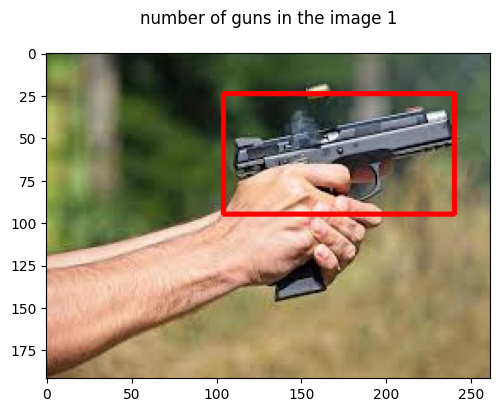

In [12]:
imgshow(280, title="number of guns in the image ")

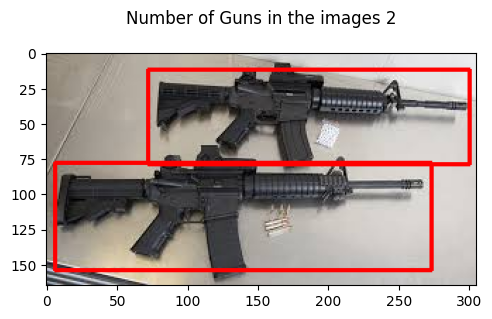

In [6]:
imgshow(119, title="Number of Guns in the images ")

# Custom dataset class for loading all images and labels and processing image

In [13]:
import os

If device is defined outside the class, it might not be directly accessible inside the class unless explicitly passed or referenced, so passing device as argument in GunData Class. 

Load images and their label files from directories

Preprocess and convert them to tensors

Return them in the format required by torchvision's Faster R-CNN model

### target dictionary format expected by torchvision's built-in Faster R-CNN implementation :

| Key        | Description                    |
| ---------- | ------------------------------ |
| `boxes`    | List of bounding boxes (N, 4)  |
| `area`     | Area of each box               |
| `image_id` | Unique image ID (can be index) |
| `labels`   | Class labels (for each box)    |


In [14]:
class Gun_Data(Dataset):

    # Pass device as an argument to the class
    def __init__(self,root, device):
        self.image_path = root+"Images/"
        self.labels_path = root+"Labels/"
        self.device = device # where you want your data tensors to reside
        
    # List of image file names, sorted alphabetically
        self.img_name = [img for img in sorted(os.listdir(self.image_path))] 
        self.label_name = [label for label in sorted(os.listdir(self.labels_path))]
        
# Load One Image and Label
    def __getitem__(self,idx):
        image_path =  os.path.join(self.image_path , str(self.img_name[idx]))
        image = cv2.imread(image_path)
        img_rgb = cv2.cvtColor(image,cv2.COLOR_BGR2RGB).astype(np.float32)

        img_res = img_rgb/255
        img_res = torch.as_tensor(img_res).permute(2,0,1) # Converts to a PyTorch tensor of shape [C, H, W]

       # Load Corresponding Bounding Boxes
        label_name  = self.img_name[idx][:-4] + "txt"
        label_path = os.path.join(self.labels_path , str(label_name))
        # Finds label file matching the image (e.g., 12.jpeg → 12.txt). Parses bounding boxes in [x1 y1 x2 y2] format

        with open(label_path,"r") as label_file:
            l_count = int(label_file.readline()) # first line = number of boxes
            box=[]
            for i in range(l_count):
                box.append(list(map(int,label_file.readline().split())))
                
        target={} # Target Dictionary for Faster R-CNN
        area=[]
        labels=[]

        for i in range(len(box)): #  Computes bounding box area = width × height
            a = (box[i][2] - box[i][0]) * (box[i][3] -  box[i][1])
            area.append(a)

        for i in range(len(box)):
            labels.append(1)  # Class 1 = 'gun'
            
# Build target Dict (expected by Faster R-CNN)
        target["boxes"] = torch.as_tensor(box)
        target["area"] =  torch.as_tensor(area)
        target["image_id"] = torch.as_tensor([idx])
        target["labels"] = torch.as_tensor(labels , dtype=torch.int64)

        # Move Data to GPU (if available)
        img_res = img_res.to(device)
        for key in target:
            if isinstance(target[key] , torch.Tensor):
                target[key] = target[key].to(device)

        return img_res,target
        
#Returns the number of images in your dataset.
    def __len__(self):
        return len(self.img_name)

# Model training
1. Builds the model (with a custom number of classes)

2. Sets the optimizer

3. Compiles and Runs the training loop, set Scheduler

4. For Validation it keeps the model in .train() but use torch.no_grad(). This means when model(images, targets) is called in train-mode it will return the training loss dict **instead of predicted boxes** (which torchvision returns in eval mode). Using train-mode+no_grad gives **validation losses** that are compatible with training losses without switching the model to .eval() which would return predictions instead.

In [ ]:

class Model:
    def __init__(self, num_classes, device):
        self.num_classes = num_classes
        self.device = device
        self.model = self.create_model().to(device)  # move to device immediately
        self.optimizer = None

    def create_model(self):
        # Load pretrained Faster R-CNN with ResNet50 backbone
        # Handle both old and new torchvision APIs
        try:
            # Newer API (torchvision >= 0.13-ish)
            from torchvision.models.detection import FasterRCNN_ResNet50_FPN_Weights
            weights = FasterRCNN_ResNet50_FPN_Weights.DEFAULT
            model = fasterrcnn_resnet50_fpn(weights=weights)
        except Exception:
            # Fallback for older versions
            model = fasterrcnn_resnet50_fpn(pretrained=True)

        # Replace the classification head with correct number of classes
        in_features = model.roi_heads.box_predictor.cls_score.in_features
        model.roi_heads.box_predictor = FastRCNNPredictor(in_features, self.num_classes)
        return model

# In Keras, .compile() is mandatory because we define optimizer, loss, and metrics before training.
# But in PyTorch, there’s no built-in .compile() step. Instead -----
# We directly create an optimizer in our training script, Losses are usually part of the model or written explicitly.
 # CAN SKIP COMPILER (REDUDANT, just mimicking keras style)
    def compiler(self, optimizer): 
        """Attach optimizer to the model."""
        self.optimizer = optimizer

    def train(self, train_data, val_data, num_epochs, scheduler=None):
        """
        Train and validate. Note: validation remains in .train() mode (with no_grad)
        so that the model returns a loss dict instead of predictions.
        """
        if self.optimizer is None:
            raise RuntimeError("Call .compiler(optimizer) before .train().")

        train_losses = []
        val_losses = []

        for epoch in range(num_epochs):
            # ---------------------- TRAINING ----------------------
            self.model.train()
            running_train_loss = 0.0

            for imgs, targets in train_data:
                imgs = [img.to(self.device) for img in imgs]
                targets = [{k: v.to(self.device) for k, v in t.items()} for t in targets]

                loss_dict = self.model(imgs, targets)  # dict of losses
                total_loss = sum(v for v in loss_dict.values())

                self.optimizer.zero_grad()
                total_loss.backward()
                self.optimizer.step()

                running_train_loss += total_loss.item()

            avg_train_loss = running_train_loss / max(1, len(train_data))
            train_losses.append(avg_train_loss)

            # ---------------------- VALIDATION ----------------------
            # Keep in train mode for loss calculation; disable grads
            self.model.train()
            running_val_loss = 0.0
            with torch.no_grad():
                for imgs, targets in val_data:
                    imgs = [img.to(self.device) for img in imgs]
                    targets = [{k: v.to(self.device) for k, v in t.items()} for t in targets]

                    loss_dict = self.model(imgs, targets)  # dict again
                    total_val_loss = sum(v for v in loss_dict.values())
                    running_val_loss += total_val_loss.item()

            avg_val_loss = running_val_loss / max(1, len(val_data))
            val_losses.append(avg_val_loss)

            # ---------------------- LOGGING ----------------------
            print(f"Epoch [{epoch+1}/{num_epochs}]  "
                  f"Train Loss: {avg_train_loss:.4f}  "
                  f"Val Loss: {avg_val_loss:.4f}")

            # ---------------------- LR SCHEDULER ----------------------
            if scheduler is not None:
                scheduler.step()

        return train_losses, val_losses


In [27]:
def run_inference(model, device, dataset, number=None, score_threshold=0.5):
    import random
    if number is None:
        number = random.randint(0, len(dataset) - 1)

    img, target = dataset[number]

    model.eval()
    with torch.no_grad():
        prediction = model([img.to(device)])[0]

    boxes = prediction['boxes'].detach().cpu().numpy()
    scores = prediction['scores'].detach().cpu().numpy()
    labels = prediction['labels'].detach().cpu().numpy()

    keep = scores >= score_threshold
    boxes = boxes[keep]
    scores = scores[keep]
    labels = labels[keep]

    img_cpu = img.detach().cpu()

    return {"boxes": boxes, "scores": scores, "labels": labels}, target, img_cpu

In [19]:
from torch.utils.data import random_split

In [20]:
# Device setup
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# ===== Dataset =====
dataset = Gun_Data('/kaggle/input/guns-object-detection/', device)

# Train/Val split
train_size = int(0.8 * len(dataset))
val_size = len(dataset) - train_size
train_dataset, val_dataset = random_split(dataset, [train_size, val_size])


In [21]:
# DataLoader
def collate_fn(batch):
    return tuple(zip(*batch))

train_loader = DataLoader(train_dataset, batch_size=3, shuffle=True, num_workers=0, collate_fn=collate_fn)
val_loader = DataLoader(val_dataset, batch_size=3, shuffle=False, num_workers=0, collate_fn=collate_fn)


In [22]:
# ===== Model =====
rcnn = Model(num_classes=2, device=device)  # 1 class (gun) + background

# Optimizer & Scheduler
optimizer = torch.optim.Adam(rcnn.model.parameters(), lr=0.0001)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.1)
rcnn.compiler(optimizer)


Downloading: "https://download.pytorch.org/models/fasterrcnn_resnet50_fpn_coco-258fb6c6.pth" to /root/.cache/torch/hub/checkpoints/fasterrcnn_resnet50_fpn_coco-258fb6c6.pth
100%|██████████| 160M/160M [00:07<00:00, 23.6MB/s] 


In [23]:
# ===== Train =====
rcnn.train(train_loader, val_loader, num_epochs=20, scheduler=scheduler)

Epoch [1/20]  Train Loss: 0.2571  Val Loss: 0.2415
Epoch [2/20]  Train Loss: 0.2018  Val Loss: 0.1801
Epoch [3/20]  Train Loss: 0.1760  Val Loss: 0.1871
Epoch [4/20]  Train Loss: 0.1463  Val Loss: 0.1695
Epoch [5/20]  Train Loss: 0.1248  Val Loss: 0.1793
Epoch [6/20]  Train Loss: 0.1071  Val Loss: 0.1803
Epoch [7/20]  Train Loss: 0.0915  Val Loss: 0.2114
Epoch [8/20]  Train Loss: 0.0853  Val Loss: 0.1914
Epoch [9/20]  Train Loss: 0.0844  Val Loss: 0.2394
Epoch [10/20]  Train Loss: 0.0832  Val Loss: 0.2213
Epoch [11/20]  Train Loss: 0.0654  Val Loss: 0.1843
Epoch [12/20]  Train Loss: 0.0518  Val Loss: 0.1935
Epoch [13/20]  Train Loss: 0.0457  Val Loss: 0.2075
Epoch [14/20]  Train Loss: 0.0421  Val Loss: 0.2096
Epoch [15/20]  Train Loss: 0.0394  Val Loss: 0.2136
Epoch [16/20]  Train Loss: 0.0367  Val Loss: 0.2188
Epoch [17/20]  Train Loss: 0.0346  Val Loss: 0.2204
Epoch [18/20]  Train Loss: 0.0333  Val Loss: 0.2275
Epoch [19/20]  Train Loss: 0.0319  Val Loss: 0.2308
Epoch [20/20]  Train 

([0.25711991269601864,
  0.2017795243457462,
  0.17596751786349865,
  0.14625867916626878,
  0.12482510682906997,
  0.10710742002290287,
  0.0914902819341488,
  0.08526988821418098,
  0.08442890037144168,
  0.08322093928797861,
  0.06537873214215376,
  0.05177025126523516,
  0.04565031070973766,
  0.04208415252773949,
  0.039366641364405666,
  0.03666030864618468,
  0.0345660907561692,
  0.0332531678710091,
  0.03192297836995862,
  0.031410078120449283],
 [0.24149689143118652,
  0.18007108277600745,
  0.1870782634486323,
  0.169509122553079,
  0.17932776458885358,
  0.1803435566632644,
  0.211427907904853,
  0.19137378458095633,
  0.2394479095287945,
  0.2212591427175895,
  0.1842522135247355,
  0.19354250703168951,
  0.20751309848350027,
  0.20963816603888635,
  0.21359219434468643,
  0.218786075387312,
  0.22039927963329398,
  0.22747799203447674,
  0.2308332450363947,
  0.23497211512016214])

In [24]:
from torchvision.ops import nms

def apply_nms(prediction, iou_threshold=0.5):
    # Ensure boxes and scores are tensors
    boxes = prediction['boxes']
    scores = prediction['scores']

    # Convert to tensor if numpy array
    if not isinstance(boxes, torch.Tensor):
        boxes = torch.tensor(boxes)
    if not isinstance(scores, torch.Tensor):
        scores = torch.tensor(scores)

    keep = nms(boxes, scores, iou_threshold)
    
    # Return filtered prediction
    return {
        'boxes': boxes[keep],
        'scores': scores[keep],
        'labels': prediction['labels'][keep]
    }


Faster R-CNN Output Format in PyTorch (Torchvision)<br>
When using torchvision.models.detection.fasterrcnn_resnet50_fpn, the bounding boxes returned by the model are in the format:
[x_min, y_min, x_max, y_max]


This is the same as:
x1, y1, x2, y2

Where:
- (x_min, y_min) is the top-left corner of the box.
- (x_max, y_max) is the bottom-right corner.

In [29]:
# For plotting predictions and ground-truth using matplotlib.
def plot_img_bbox(img, target, size=5):
    """Plot image with bounding boxes."""
    img_cv = cv2.cvtColor(np.array(img), cv2.COLOR_RGB2BGR)
    for box in target["boxes"]:
        x_min, y_min, x_max, y_max = box.tolist()
        cv2.rectangle(img_cv, (int(x_min), int(y_min)), (int(x_max), int(y_max)), (0, 0, 255), 2)

    aspect_ratio = img_cv.shape[0] / img_cv.shape[1]
    plt.figure(figsize=(size + aspect_ratio, size))
    plt.imshow(cv2.cvtColor(img_cv, cv2.COLOR_BGR2RGB))
    plt.axis("off")
    plt.show()

In [30]:
from torchvision.transforms.functional import to_pil_image

def torch_to_pil(img_tensor):
    """
    Converts a torch tensor image (C, H, W) to a PIL image for plotting.
    Automatically removes batch dimension if present.
    """
    if img_tensor.dim() == 4:
        img_tensor = img_tensor.squeeze(0)  # remove batch
    return to_pil_image(img_tensor)


### ===== Test on a Sample =====

Ground Truth:


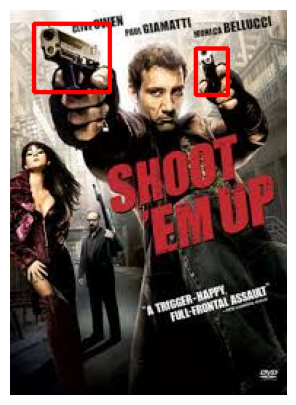

Prediction after NMS:


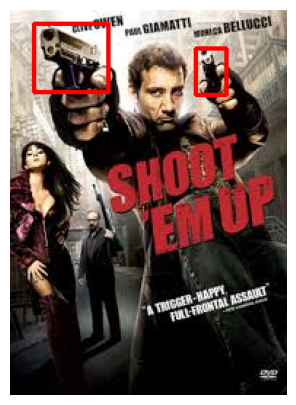

In [31]:
prediction, target, img = run_inference(rcnn.model, rcnn.device, dataset, number=10, score_threshold=0.7)

# Apply NMS (directly)
nms_prediction = apply_nms(prediction, iou_threshold=0.7)

# Ground Truth: refers to the real, correct labels and bounding boxes that describe what’s actually in the image.
# - the real boxes and labels from dataset (target)

print("Ground Truth:")
plot_img_bbox(torch_to_pil(img), target)

# Predictions after NMS - what model guessed, cleaned up using Non-Max Suppression
print("Prediction after NMS:")
plot_img_bbox(torch_to_pil(img), nms_prediction)



Ground Truth:


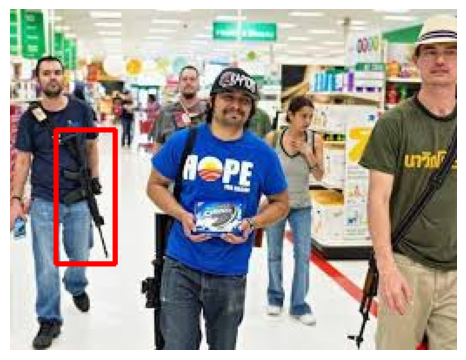

Prediction after NMS:


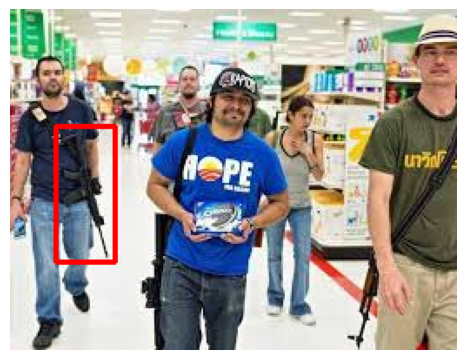

In [32]:
prediction, target, img = run_inference(rcnn.model, rcnn.device, dataset, number=130, score_threshold=0.7)

# Apply NMS (directly)
nms_prediction = apply_nms(prediction, iou_threshold=0.7)

# Ground Truth
print("Ground Truth:")
plot_img_bbox(torch_to_pil(img), target)

# Predictions after NMS
print("Prediction after NMS:")
plot_img_bbox(torch_to_pil(img), nms_prediction)

